# Contenido 
> ## Primer parte
> > - [Creando una red simple](#firstNet)
> ## Segunda parte
> > - [Redes convolucionales](#cnn)
> > - [Convoluciones](#convoluciones)
> > - [Mi primer modelo](#reddecente)
> > > - [Cargando datos](#loaddata)
> ## Tercera parte
> > - [Explosión y Desvanecimiento](#explodesva)
> > - [Resblocks](#resblocks)
> ## Cuarta parte
> > - [¿Cómo hacer predicciones](#predicciones)
> > - [Sobreajuste, valid loss y train loss](#overfitting)
> ## Quinta parte
> > - [Optimizadores](#optimizadores)
> > - [Cómo partir nuestro modelo](#partmodel)
> ## Sexta parte
> > - [Funciones de pérdida](#functionsloss)

In [2]:
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()
import torch 
import torch.nn as nn
from math import prod, sqrt

# Vector de entrada 

Pensemos que x es un vector en R^5
y queremos construir una red neuronal pequeñisima que termine con un vector en R^3. Ahora, en pytorch *todo* funciona en batches (lotes), asíí que pensemos que tenemos lotes de tamaño 4. 

In [4]:
bs = 4
n = 5

x = torch.rand(bs, n)

# 1er parte
<a id='firstNet'><h1><strong>Creando la red</strong></h1></a>

**nn** es lo que tiene pytorch para hacer redes neuronales. Un módulo (nn.Module) de pytorch es una función con parámetros. 

In [5]:

#nn.Sequential: Lo que espera es que le pases un modulo 
#Un modulo de pytorch es básicamente una red neuronal, o sea
#una función parámetros. 

red_neuronal = nn.Sequential(
    #Las funciones las aplica en secuencia
    nn.Linear(5,10),#crea una transformación afin de R5 en R10 
    #Inicializa con parámetros aleatorios
    nn.ReLU(), #si ya esta en R10, la siguien función debe 
    #de empezar en R10  
    nn.Linear(10,8), 
    nn.Sigmoid(), 
    nn.Linear(8,3)
)

# Usando la red neuronal 


In [6]:
red_neuronal(x)

tensor([[-0.2177,  0.4777, -0.0688],
        [-0.2321,  0.4783, -0.0712],
        [-0.2367,  0.4774, -0.0735],
        [-0.2145,  0.4966, -0.0630]], grad_fn=<AddmmBackward>)

In [7]:
red_neuronal(x).shape
# 4 por el tamaño de la batch
# 3 porque terminamos en dimensióón tres. 

torch.Size([4, 3])

# Examinando la red neuronal 

In [8]:
red_neuronal


Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=8, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=8, out_features=3, bias=True)
)

In [9]:
a = red_neuronal[0]

In [10]:
list(a.parameters())

[Parameter containing:
 tensor([[ 0.4113, -0.0612,  0.4044,  0.3036,  0.2759],
         [-0.0325, -0.3633, -0.0520, -0.2278, -0.0757],
         [ 0.3002,  0.2512,  0.1433, -0.0022,  0.0635],
         [-0.0772, -0.2852, -0.0098, -0.0032, -0.0641],
         [-0.2402, -0.2902,  0.1215,  0.0073, -0.2075],
         [-0.4253,  0.1266, -0.1859, -0.2548,  0.3890],
         [ 0.4356,  0.4221, -0.3377,  0.1450, -0.0062],
         [-0.1172, -0.1743, -0.2519, -0.3433,  0.3702],
         [ 0.2097, -0.2289,  0.0125, -0.3217,  0.1656],
         [ 0.4417,  0.0766,  0.4356,  0.1957,  0.0167]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1853, -0.3950,  0.0104,  0.0229, -0.1261,  0.3635,  0.2366, -0.0993,
         -0.2915,  0.4209], requires_grad=True)]

La matriz máa grande es la matriz por la que multiplica y el vector pequeño es el vector que le suma.

La matriz máás grande son los datos que va a aprender la red. 

# 2da Parte
<a id="cnn"><h1><strong>Redes convolucionales</strong></h1></a>

In [11]:
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()

In [15]:
# Cargamos una imagen
img = fv.PILImage.create("storage/recursos/ideal.jpg")
# Convertimos a tensor
img_tensor = to_tensor(img)

In [17]:
img_tensor.shape

torch.Size([3, 808, 808])

In [30]:
# Definimos una convolución 
# De entrada tiene 3 filtros
# De salida tiene 1 
conv = nn.Conv2d(3,3,kernel_size=3)
# Kernel_size es de cuanto por cuanto es el filtro 

#Si cambiamos el filtro con valor 1 por uno con valor 3, nos da una imagen rgb 


In [31]:
conv(img_tensor[None])

tensor([[[[-0.0149, -0.0149, -0.0149,  ..., -0.0149, -0.0149, -0.0149],
          [-0.0149, -0.0149, -0.0149,  ..., -0.0149, -0.0149, -0.0149],
          [-0.0149, -0.0149, -0.0149,  ..., -0.0149, -0.0149, -0.0149],
          ...,
          [ 0.0714,  0.0695,  0.0660,  ...,  0.0288,  0.0297,  0.0308],
          [ 0.0742,  0.0705,  0.0675,  ...,  0.0282,  0.0288,  0.0297],
          [ 0.0756,  0.0720,  0.0687,  ...,  0.0281,  0.0290,  0.0283]],

         [[-0.0242, -0.0242, -0.0242,  ..., -0.0242, -0.0242, -0.0242],
          [-0.0242, -0.0242, -0.0242,  ..., -0.0242, -0.0242, -0.0242],
          [-0.0242, -0.0242, -0.0242,  ..., -0.0242, -0.0242, -0.0242],
          ...,
          [-0.0744, -0.0717, -0.0679,  ..., -0.0524, -0.0511, -0.0514],
          [-0.0738, -0.0714, -0.0701,  ..., -0.0505, -0.0524, -0.0511],
          [-0.0756, -0.0730, -0.0694,  ..., -0.0502, -0.0509, -0.0514]],

         [[-0.1047, -0.1047, -0.1047,  ..., -0.1047, -0.1047, -0.1047],
          [-0.1047, -0.1047, -

<a id="convoluciones"><h1><strong>Convoluciones</strong></h1></a>

Si tenemos una imagen con 3 canales (RGB). un filtro de 3x3 
tiene que tener 27 numeritos, este último x3 corresponde
a los tres canales de la imagen.

Cada filtro normalmente es una matriz de 3 x 3, dependiendo 
de los números en esta matriz. Se detectan cosas diferentes. 

- Supongamos que tomamos un montón: 
* tenemos una imagen de 200 de alto y 300 de ancho de tres 
  capaz (RGB) 
* Aplicamos 4 filtros 
* Obtendremos una imagen de 4 capaz, en la que cada capa 
  es de 198 de alto y 298 de ancho. 
- Dado que cada filtro es de 3 por 3, el pixel que tomamos en 
  la imagen corresponde al de enmedio en el filtro. 
  Esto nos hace perder un pixel de lado izquiero y otro 
  de lado derecho tras evaluar toda la fila. Normalmente
  se añade un pixel negro para conservar las dimensiones. 


In [32]:
conv(img_tensor[None]).shape 
# Observemos que hemos perdido dos pixeles, esto es por lo escrito anteriormente

# El primer 1 es de la batch, que solo tiene una sola imagen
# El segundo 1 es porque puse que solo queria un filtro 

torch.Size([1, 3, 806, 806])

In [33]:
f = to_pil(conv(img_tensor[None])[0]);

In [21]:
#f.save("filtered_image.jpg")

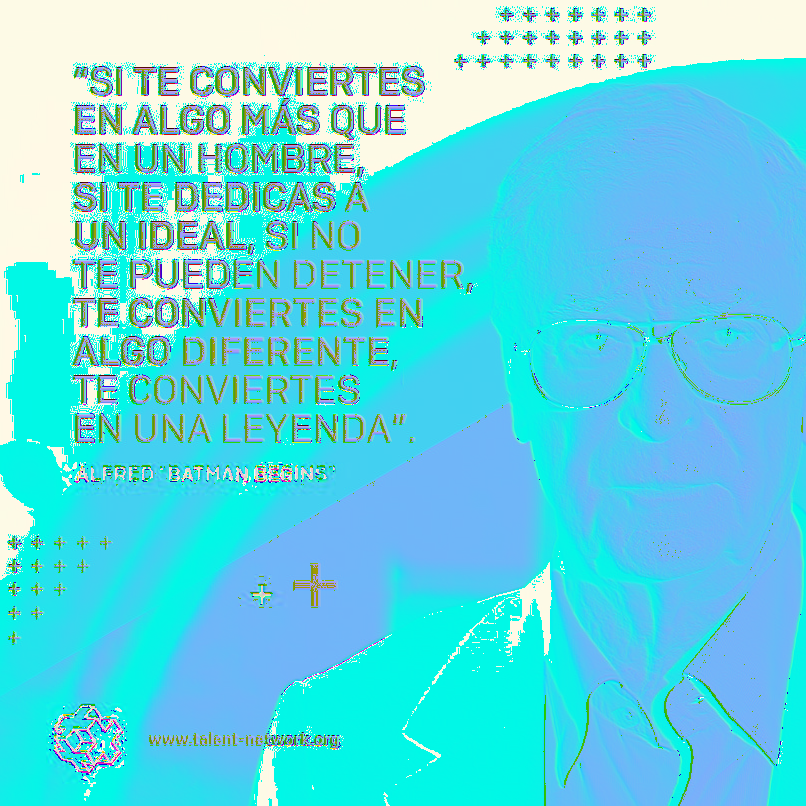

In [34]:
f

<a id="reddecente"><h2><strong>Creando una red más elaborada y mi primer modelo</strong></h2></a>

In [3]:
# Esta capa servirá para conectar las convolucionales con las lineas densas
class Flatten(nn.Module): #Para hacer un modulo de pytorch, tienes que heredar
    # de nn.Module
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # return (x.squeeze()) Esto funciona solo si la batchsize es >1
        # si es 1, esto se lo va a quitar
        # solución 
        return (x.view(x.shape[0], -1)) 
        #x.shape[0] es la batchsize
        #-1 si se lo pasas a reshape o a view les dice algo 
        # como tú adivina de que tamaño debe de ser esto 
    
# Para tener idea de qué tan grande es nuestro modelo
def num_params(model):
    from math import prod, sqrt
    #total=0
    #for p in model.parameters():
        #num=1
        #for s in list(p.size()):
            #num *= s
        #total += num
        
    # Una manera de hacer más optimo lo anterior 
    total = sum([prod(p.shape) for p in model.parameters()])
    return (total)

In [4]:
# Primer intento: red neuronal convolucional 
model = nn.Sequential(
    # Convolución
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.ReLU(),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2), 
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(), 
    nn.Linear(256, 102))
# Stride es cuanto brinca 
# padding=1 es que le va a poner un borde completamente negro
# a la imagen para no perder pixeles

In [47]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): AdaptiveAvgPool2d(output_size=1)
  (15): Flatten()
  (16): Linear(in_features=512, out_features=256, bias=True)
  (17): ReLU()
  (18): Linear(in_features=256, out_features=102, bias=True)
)

In [48]:
num_params(model)

1726790

In [49]:
img = torch.rand(10,3,256,256)

In [52]:
model(img).shape # donde 10 es la batch size

torch.Size([10, 102])

<a id="loaddata"><h2><strong>Cargando datos</strong></h2></a>

In [5]:
def load_data(folder, img_size, batch_size): 
    tfms = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    
    data = fv.DataBlock(blocks   = (fv.ImageBlock, fv.CategoryBlock),
                       get_items = fv.get_image_files,
                       get_y     = lambda x: x.parent.name, 
                       splitter  = fv.GrandparentSplitter(),
                       item_tfms = fv.Resize(img_size),
                       batch_tfms= tfms,
                       )
    
    return (data.dataloaders(folder, bs=batch_size))

In [6]:
data = load_data("storage/recursos/flowers/", 256, 64)

In [59]:
data.c # c te dice el número de clases que tienes en los 
# datos

102

In [64]:
# Creamos el aprendedor
learn = fv.Learner(data, model, metrics=fv.accuracy) 

In [67]:
model[0]


Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [70]:
# Observemos el primer número en "param"
# es 1,568 que viene de que tenemos 
# 3 de entrada
# 32 de salida
# un kernel_size de 4*4
3*32*4*4 == 1536
# si bien, el número que tenemos en el param es 1568 
# y en nuestro proceso obtuvimos 1536, se deba a que las convoluciones
# multiplican pero además al final tambíen suman un vector porque son transformaciones afines

True

In [62]:
learn.summary()
# Lo que hace summary es tomar una batch e ir viendo en cada parte
# de que tamaño son las imagenes

# Entonces encontramos todas las capas que tiene y de que tamaño queda la imagen después de pasar por 
# esa capa

Sequential (Input shape: ['64 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 128 x 128  1,568      True      
________________________________________________________________
ReLU                 64 x 32 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            64 x 32 x 64 x 64    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 64    18,496     True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               64 x 128 x 32 x 32   73,856     True      
_________________________________________________

In [66]:
learn.fit_one_cycle(12, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.269083,3.291491,0.171937,00:14
1,3.260221,3.299656,0.152174,00:14
2,3.203975,3.164369,0.166008,00:14
3,3.057010,2.937423,0.217391,00:14
4,2.873773,2.815746,0.262846,00:14
5,2.739998,2.745231,0.268775,00:14
6,2.564617,2.603238,0.290514,00:14
7,2.444068,2.418584,0.333992,00:13
8,2.272707,2.280846,0.375494,00:14
9,2.148560,2.189793,0.403162,00:14


Observamos que nuestro train_loss es menor que nuestro valid_loss, lo que significa que estamos comenzando a tener
overfitting. 

<a id ="explodesva"><h1><strong>Explosión y Desvanecimiento</strong></h1></a>

Vamos a "simular" una red neuronal completamente conectada con parámetros aleatorios. Digamos que x es la entrada y tenemos batch size de 64.

In [2]:
x = torch.randn(64, 100) #64 vectores de tamaño 100

In [3]:
x.mean(), x.std() #std es la desviación estandar



Ahora, en cada capa vamos a multiplicar por una matriz y aplicar una función de activación (e.g. relu)


In [4]:
# una red con 20 capas trono :( 
for i in range(20):
    x @= torch.randn(100, 100)
    torch.relu_(x)


In [ ]:
x

In [ ]:
x.std()

Wait! Exploto!

# ¿Qué podemos hacer?

Hay varias cosas que se inventaron para tratar de amellorar este problema y poder entrenar redes mucho más profundas: 

- Inicializar correctamente las capas
- BatchNorm 
- ResBlocks

In [ ]:
# En el caso de Inicializar correctamente las capas
# Para que no truene debemos de multiplicar nuestro 
# vector por la raíz cuadrado de 2/100
for i in range(50): 
    x @= torch.randn(100, 100)*sqrt(2/100) # Vuelve estable
    # pasar por la red neuronal si inicializamos así
    torch.relu_(x)

x.std()



Todo esto fue para redes neuronales completamente conectadas y activación de Relu

Nota: Si cambiamos relu por otra cosa, tendrémos que multiplicar por otra cosa para volverlo estable
Batchnorm

Esta es una idea muy sencilla. ¿Por qué no normalizar para tener desviación estándar 1 y media 0 después de cada capa? Pues eso es una de las dos cosas que intenta hacer batchnorm:

x <- x-u/o

Pero ¿cómo? En realidad no conocemos la desviación estándar y la media de x en la capa número 14. Entonces lo que hacemos es usar la desviación estándar y la media en la batch.

Nota: "u" y "o" son vectores con el mismo número de canales que x sin contar la batch_size. Es decir, cada canal podría tener diferentes media y desviación.

Para entonces nunca vas a poder predecir cosas con diferente media o desviación estándar!!

Entonces lo que hace batchnorm es además decide, independientemente, dos parámetros uno multiplicativo (y (gama)) y uno aditivo (beta). Estos parámetros tienen el mismo número de canales que x (obviamente sin contar la batch).

x <- yx+beta

Casi siempre inicializamos y = (1,1,1;...,1) y beta = (0,0,0,...,0)

En código:


In [ ]:
import torch.nn as nn

In [ ]:
B = nn.BatchNorm1d(20) #1d para vectores

In [ ]:
x = torch.rand(64, 20)
B(x)

In [ ]:
B.weight #Estos números son parámetros, van aprendiendo

In [ ]:
B.bias

Batchnorm básicamente quita el overfitting y el desvanecimiento de la gradiente. Por lo tanto usa Batchnorm en todas las redes que hagas Vidale

In [ ]:
# Suponiendo que ya estás creando tu red, 
# debería de empezar algo así

nn.Sequential(nn.BatchNorm2d(3), # iniciar con batchnorm
              # para normalizar los datos es una buena 
              # práctica
             nn.Conv2d(3,16,kernel_size=3), 
             nn.ReLU(), 
             nn.BatchNorm2d(16))

<a id="resblocks"><h1><strong>Resblocks</strong></h1></a>

Aún así, a las redes neuronales les cuesta trabajo aprender funciones sencillas (como por ejemplo la identidad).

Entonces se les ocurrió que en vez de que cada "capa" calcule un valor, que más bien cada capa calcule "un error" o "residuo" (por eso residual nets).

Es decir, que en vez de directamente calcular cuánto debe valer la salida, mejor que calcule cuánto hay que sumarle a la entrada para producir una buena salida:

x -> f(x) lo reemplazamos por x -> x + f(x)

Donde f podría ser una mini-red neuronal con unas 2 o 3 capas.

De esta manera, los gradientes pueden "brincar" más sencillamente.

O sea, en lugar de ir tipo:

   - PuntoA -> intermedio1 -> intermedio2 -> PuntoB

van algo así:

    - PuntoA -> PuntoB

En código:


In [ ]:
class ResBlock(nn.Module): 
    def __init__(self, residual):
        super().__init__()
        self.residual = residual 
        
    def forward(self, x):
        return (x + self.residual(x))



¿Cómo lo usamos?

Hay varias maneras de poner la red residual. Aquí hay una posibilidad, pero hay muchas. Experimenta!!


In [ ]:
def crear_residual(filters): # Número de filtros de entrada 
    # número de filtros de x básciamente
    bottleneck = (filters+1)//2
    residual = nn.Sequential(
        # Es como una compresión
        nn.Conv2d(filters, bottleneck, kernel_size=1), #Esto es como para reducir el tamaño 
        nn.ReLU(), 
        nn.BatchNorm2d(bottleneck),
        nn.Conv2d(bottleneck, bottleneck, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(bottleneck),
        nn.Conv2d(bottleneck, filters, kernel_size=1),
        nn.ReLU(),
        # Es importante terminar con batchnorm
        nn.BatchNorm2d(filters)
    )
    nn.init.constant_(residual[-1].weight, 0) 
    return (residual)



Además este último batchnorm deberá estar inicializado con 0's (en vez de 1's) para y, como para que empiece siendo la identidad. Esto lo hacemos con nn.init.constant_. Porque quiero que empiece siendo la identidad y a partir de ahí aprenda cosas.


In [ ]:
ResBlock(crear_residual(16))



Ya tenemos todos los ingredientes de resnet18, resnet34, etcétera!!


In [ ]:
import fastai.vision.all as fv

In [ ]:
fv.resnet18()

<a id="predicciones"><h1><strong>¿Cómo hacer predicciones?</strong></h1></a> 



## *model.eval() vs model.train()*

Los modelos tienen dos "modos": el modo "evaluación" y el modo "entrenamiento"

In [ ]:
model.train(); # poner al modelo en modo entrenamiento

In [ ]:
model.eval(); # poner al modelo en modo evaluación

Algunas capas (como BatchNorm y Dropout) cambian su comportamineto radicalmente; es como si entrenas jugar Volleybal con un chaleco con peso, y ya el día del torneo te lo quitas y todo lo sientes más ligero.

A los modelos les puedes preguntar si están entrenando o en evaluación: 

In [ ]:
model.training # regresa false si el modelo esta en modo evaluación

**fastai** se encarga solito de ponerlo en un modo u otro, pero si lo haecs manualmente, **debes recordarlo**

## Para hacer predicciones



In [ ]:
# La manera facil 
learn.predict('flowers/valid/bird-of-paradise/image_021.jpg')
# Esto te regresa tres cosas
# El nombre, ya codificado
# El numero de la clase
# Un tensor (al que le aplicamos sofmax para que represente probabilidades)

In [ ]:
cls, index, probs = learn.predict('flowers/valid/bird-of-paradise/image_021.jpg')
torch.softmax(probs, dim=0)
# Nos devuelve un tensor de probabilidades

In [ ]:
# Lo anterior es para una sola imagen, pero lo ideal es para muchas
some_images = fv.get_image_files("flowers/valid/")
# En general aqui no tendría que ser el set de validación 
# ni el de entrenamiento, deberia ser ya un set con el que no
# hemos trabajado
len(some_images)

In [ ]:
# creamos un test data loaders
# dls: data loaders
test_dl = learn.dls.test_dl(some_images)

In [ ]:
preds = leanr.get_preds(dl=test_dl) # lo hace en baches

In [ ]:
preds[0].shape
# regresa dos números el de la posición cero: número de imagenes
# posición uno: categorias

In [ ]:
# Si las quiero decodificar necesito 
probs, I = preds[0].max(dim=1)
# O sea, para cada una de las tantas imagenes dame el máximo

In [1]:
# Enonces si quiero hacer las predicciones
# I son mis indices y estan en el mismo orden que 
# some_images
# por lo que únicamente hago 
for file, pred_clas in zip(some_images, I): 
    print(f"{file} is {learn.dls.vocab[pred_clas]}")

# Manualmente con pytorch

In [ ]:
import PIL

In [ ]:
x = to_tensor(PIL.Image.open("flowers/valid/birds-of-paradise/image_921.jpg"))

In [ ]:
model.eval()

In [2]:
y = model(x[None].cuda())

In [ ]:
y.shape # [1,102]

In [ ]:
y.max(dim=1) #dim=1 porque en 1 es donde esta 102
# regresa el valor del tensor y su indice

In [3]:
learn.dls.vocab[9] # Indice obtenido con t.max(dim=1)

<a id="overfitting"><h1><strong>Sobreajuste, Valid Loss y Train Loss</strong></h1></a>

In [6]:
model = nn.Sequential(
    # Convolución
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.ReLU(),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2), 
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(), 
    nn.Linear(256, 102))

In [ ]:
learn = fv.Learner(data, model, metrics=fv.accuracy)

In [ ]:
learn.fit_one_cycle(50, 1e-3)

**Cuando empieza a subir el valid loss, significa que ya hay un sobreajuste**

Si usamos el mismo modelo, pero ahora le pasamos batchnorm 
después de cada activación. El modelo mejora muchisimo y no ocurre el sobreajuste

# ¿Por qué valid_loss es menor a train_loss al principio?

Pues hay dos razones: 

1- **Data augmentation** Las rotaciones, etc. SOLO se aplican a las de entrenamiento.

2- **BatchNorm** Sobre todo con batch_size pequeñas (aquí la tenemos grande). BatchNorm usa solo los datos de la batch para normalizar. PERO al evaluar usa de todas!

Pero claro, al final si ves cada dato 50 veces, la red empieza a "memorizarlos" y se vuelve mucho mucho más chico el train loss que el valid loss 

**Observación** Con BatchNorm2d ya es muy díficil sobreajustar! Estuvimos mejorando hasta cierto punto y después ya nos detuvimos

<a id = "optimizadores"><h1><strong>Sobre optimizadores</strong></h1></a>
## Momento 

En algún momento comparamos entrenar una red neuronal a bajar por una montaña con mucha niebla. 

En nuestra analogía, la montaña representa la función de pérdida y la persona es la red neuronal. 

Si vas bajando en una dirección y de pronto caes encima de una piedria que, al menos localmente, te haec pensar que ya debes ir de vuelta ¿qué haces? Obviamente no vas a darle vuelta y caminar hacia dde donde venías!

El momento trata de simular esto: Si vas bajando en cierta dirección, pues como que deberías continuar en esa misma dirección aunque temporalmente los gradientes apunten a otro lado.

In [ ]:
optin = fv.partial(fv.SGD, mom=0.9)

In [ ]:
learn = fv.Learner(data, model_bn, opt_func=optin, metrics=fv.accuracy)

In [ ]:
learn.fit_one_cycle()

# One Cycle Training

¿Qué hace *fit_one_cycle*?

In [ ]:
learn.recorder.plot_sched()
# Los optimizadores como Ada, necesita cierto calentamiento 
# al inicio, de ahí que funcione  subir y bajar el learning rate
# tal como lo muestra la gŕafica

Para controla esa figura se puede usar 

div, div_final, pct_start

*div* significa, por cuanto tienes que dividir la learning rate al principio y *final*, por cuanto tienes que dividir al final.
*pct_start* es cuanto calentamiento hace.

In [4]:
learn.fit_one_cycle(1, 1e-3, div=2,div_final=10,pct_start=0.8)

## SGD, Adam, Ranger

In [ ]:
fv.doc(fv.Adan) #recomendable, usar Ranger

In [ ]:
learn = fv.Learner(data, model_bn, opt_func=fv.ranger, metrics=fv.accuracy)

In [ ]:
learn.fit_one_cycle(1,1e-3, div=0.9, final_div=1000, pct_start=0.9)
# Nos entrega mejores resultados que Adam  en una sola epoca

# Tazas de aprendizaje diferentes

Si se fijaron, en algún momento a la hora de entrenar resnet18() le pasamos una *slice* a *lr_max*

In [ ]:
learn.fit_one_cycle(4,lr_max=slice(1e-6, 1e-4))

Comentamos que era para que las primeras capas, que ya estaban entrenadas en Imagenet, no se modificaran mucho, pero las últimas si se modificaran. 

Cada modelo esta "partida" y lo que hace fastai es interpolar linealmente el rango que le das y entrenar cada pedazo con su learning rate. Esto se puede hacer en los modelos pre-hechos porque alguien de fastai (supongo que sylvain) se puso a partir manualmente los modelos. 

Si tú pones tu propio modelo, tienes que decir como partirlo si quieres que funcione entrenar con slices. 

<a id = "partmodel"><h1><strong>Cómo partir nuestro modelo</strong></h1></a>

A la hora de crear el *Learner* tienes que pasarle una función al parámetro *splitler* que tome como parámetro un modelo y te regrese los "pedazos". Vamos a hacer esto!

In [ ]:
model_bn

In [ ]:
def my_own_splitter(m):
    # la última parte esta en su propio grupo
    return ([list(group.parameters()) for group in [m[0:2], m[2:10],m[10:19],m[19:]]])

In [ ]:
learn = fv.Learner(data, model_bn, 
                  opt_func=fv.ranger, metrics=fv.accuracy,
                  splitter=my_own_splitter
                  )

In [ ]:
learn.freeze_to[-1] # congela todas excepto la última
# NOTA: Las batchnorm nunca las congela

In [ ]:
learn.summary()

In [ ]:
# A la hora de entrenar, los grupos que va a usar son: 
learn.fit_one_cycle(1, slice(1e-6, 1e-3))
# Es decir, la primer capa la entrena con 

In [5]:
# Si quisieras cambiar la última capa tendrías que hacer algo como 
model_bn[-1] = nn.Linear(256,35)
# de esta manera cambias la salida de 102 categorias a 35 categorias

#NOTA: Esta última capa no esta entrenada por lo que
# va a ser necesario que la entrenes. 

<a id="functionsloss"><h1><strong>Funciones de pérdida</strong></h1></a>

Cuando estamos clasificando flores, lo que realmente nos interesa maximizar es la accuracy: *Ejemplos bien clasificados*/*Todos los ejemplos* (o equivalentemente, minimizar la taza de error = 1 - accuracy). 

Sin embargo, claramente esta función no es buena idea tratar de maximizar directamente (sólo se fija en el máximo y deja todo lo demás) y no es siquiera continua. Entonces tenemos que minimizar otra cosa. 

Antes de explicar la función de pérdida (cross entropy), vamos a hablar de sigmoid y softmax.

In [9]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): AdaptiveAvgPool2d(output_size=1)
  (15): Flatten()
  (16): Linear(in_features=512, out_features=256, bias=True)
  (17): ReLU()
  (18): Linear(in_features=256, out_features=102, bias=True)
)

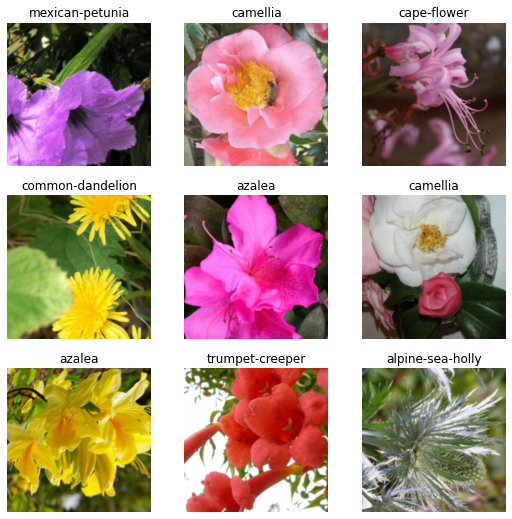

In [10]:
data.show_batch()

In [7]:
x,y = data.one_batch()

In [8]:
x.shape # x es una batch de imagenes

torch.Size([64, 3, 256, 256])

In [9]:
y,y.shape # tensor de tamaño 64 con números enteros

(TensorCategory([ 99,  54,  74,  96,  58,  57,  40,  67,  52,  96,  39,   9,   7,  53,
          10,  49,  81,  16,  72,  36,  72,  86,  41,  53,  60,  32,  52,  78,
          78,  94,  24,  35,  61,  69,  65,  25,  41,  61,  44,  28,  82,  90,
          70, 101,  59,  19,  35,  96,  17,  96,  54,  97,  38,  32,  72,  78,
          26,  25,  67,  85,   8,  29,   6,  69]),
 torch.Size([64]))

In [ ]:
model(x),model(x).shape # me regresa un tensor de 64, 102 donde
# 102 es el número de categorias y donde 
# cada número de los 64 son las probabilidades de ser cierta
# categoria
# PEEEEEEEROO
# pero son números que después de aplicarle cierta función
# representan probabilidades
# Las funciones son las siguientes...

Los números que escupe son negativos, a veces más grandes que 1, etc. Claramente no son probabilidaddes pero clásicamente lo que se hacía era agregarlo una última función de activación al output de la red neuronal. 

**Nota:** Ya no debes agregárselas, pero conceptualmente aún puedes pensar que la tiene ahí.

# Sigmoide
Queremos una función f: R -> [0,1] (continua, diferenciable, creciente). La más común es la función sigmoide o logística: 

    o(x) = e^x / 1 + e^x
    
Esto convertira el output de la red neuronal en números entre 0 y 1:



In [ ]:
torch.sigmoid(model(x))

Pero si expresan probabilidades, entonces... ¿no debería sumar 1 cada renglón?

Depende: Si cada imagen representa UNA categoria, sí. Pero si una imagen pudiera contener, por ejemplo, dos o más flores diferentes, entonces no. 

# Softmax

Softmax básicamente normaliza para que todos los renglones sumen 1: 
    softmax(x) = e^x / Summatoria e^x
    
Donde x es un vector, y la suma se hace sobre las entradas del vector. 

In [14]:
torch.softmax(model(x), dim=1)

tensor([[0.0100, 0.0099, 0.0093,  ..., 0.0100, 0.0101, 0.0095],
        [0.0100, 0.0099, 0.0093,  ..., 0.0100, 0.0101, 0.0095],
        [0.0100, 0.0099, 0.0093,  ..., 0.0100, 0.0101, 0.0095],
        ...,
        [0.0100, 0.0099, 0.0093,  ..., 0.0100, 0.0101, 0.0095],
        [0.0100, 0.0099, 0.0093,  ..., 0.0100, 0.0101, 0.0095],
        [0.0100, 0.0099, 0.0093,  ..., 0.0100, 0.0101, 0.0095]],
       grad_fn=<SoftmaxBackward>)

In [1]:
# entonces si hacemos sum, tendremos la suma de cada renglon:
torch.softmax(model(x), dim=1).sum(dim=1)

NameError: name 'torch' is not defined

In [ ]:
torch.softmax(torch.randn(5,3), dim=1)

## ¿Cómo las usamos?

Para clasificación, quisieramos entonces que lo que escupe la red neuronal, al aplicarle softmax, se viera así: 
    [0,0,1,0,0,0,0,...]
Con el "1" en la posición que corresponde a la categoría correcta. 

# MSE loos

podríamos simplemente tomarnos la distancia euclidiana, y de hecho funciona más o menos. Vamos a probar

In [ ]:
yp = model(x)
yp.shape
# tamaño de la batch y categorias

In [ ]:
y, y.shape
# ya nos regresa números enteros
# pero lo ideal sería que todo estuviese compuesto por ceros
# y un uno en la posición de su respectiva 
# categoria
# creamos un tenosr entonces

In [ ]:
bs, c = yp.shape

In [ ]:
z = torch.zeros_like(yp)#(bs, c)
z[torch.arange(bs), y] = 1

In [ ]:
z

In [ ]:
z[0]

In [ ]:
y[0]

In [ ]:
z[0][59]

In [ ]:
import torch.nn.functional as F

In [ ]:
def distancia_euclidiana(yp, y):
    yp_normalizado = torch.softmax(yp, dim=1)
    z = torch.zeros_like(yp)
    z[torch.arange(bs, device=z.device),y] = 1
    return F.mse_loss(yp_normalizado, z) #mean square error

In [ ]:
learn = fv.Learner(data, model, loss_func=distancia_euclidiana, metrics=fv.accuracy)

In [ ]:
learn.fit_one_cycle(6)

# Cross entropy

Para clasificación se usa una diferente, por razones matemáticas que están fuera del alcance de este curso, pero básicamente en términos intuitivos es la función que maximiza la probabilidad de clasificar correctamente (sale de estudios de probabilidad) 

Pensando que aplicamos softmax a *Yp* (y entonces es un vector) de tamaño c y "one-hot-encodeamos" a *y* (y entonces también es un vector de 0's y 1's) (de tamaño x):

> cross_entropy_loss(Yp, y) = - sum y*ln(Yp)

**Nota importante:** En pytorch, cross entropy supone que le pasas directamnete yp y la y, *sin softmax* y *sin one-hpt-encoding*, así lo puede calcular más rápido y con maor estabilidad numérica. 

In [ ]:
yp, y

In [ ]:
F.cross_entropy(yp, y)

In [ ]:
# copiar y pegar modelo para que no este entrenado

In [ ]:
learn = fv.Learner(data, model, loss_func=F.cross_entropy, metrics = fv.accuracy)

In [ ]:
learn.fit_one_cycle(6)